#  Decision Trees


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

import mlflow
from mlflow.models import infer_signature

# Data Sample Load

Сегодня мы будем работать с [данными ](https://www.kaggle.com/c/titanic/data) о пассажирах Титаника.

    VARIABLE DESCRIPTIONS:
    survival        Survival
                (0 = No; 1 = Yes)
    pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

    SPECIAL NOTES:
    Pclass is a proxy for socio-economic status (SES)
     1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

    Age is in Years; Fractional if Age less than One (1)
     If the Age is Estimated, it is in the form xx.5

Загрузим данные.

In [2]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Проведем небольшую предобработку данных: выкинем лишние колонки, закодируем категориальные переменные, выкинем строки в которых есть Nan.

In [4]:
def data_preprocessing(data_input):

    # Select bad columns and remove them
    cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
    data_input = data_input.drop(cols_2_drop, axis=1)

    # Replace missing values (NaN) with -999 for 'Age' feature
    data_input.loc[:, 'Age'] = data_input.Age.fillna(-999)

    # Encode 'Sex' values
    data_input['Sex'] = LabelEncoder().fit_transform(data_input['Sex'])

    # Remove all object with missing values
    data_input = data_input.dropna()

    # Encode categorical features using OneHotEncoding
    data_input = pd.get_dummies(data_input, columns=['Embarked'], prefix_sep='=')

    return data_input

In [5]:
data_preproc = data_preprocessing(data)

Намного лучше, теперь мы можем обучать на этих данных модель.

In [6]:
data_preproc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,1,22.0,1,0,7.2500,False,False,True
1,1,1,0,38.0,1,0,71.2833,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,True


In [7]:
# Set up label column
y_column = "Survived"

# Select X columns
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked=C',
       'Embarked=Q', 'Embarked=S'],
      dtype='object')

## Data Split

Разобьем данные на train и test.

**Warning!** Не забываем фиксировать  `random_state`.

In [8]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split
X = data_preproc[X_columns].values
y = data_preproc[y_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,    # 30% for test, 70% for train
                                                    random_state=123) # shuffle objects before split

## MLFlow

In [9]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Titanic")

2024/07/24 20:55:32 INFO mlflow.tracking.fluent: Experiment with name 'Titanic' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/446509872507494190', creation_time=1721843732789, experiment_id='446509872507494190', last_update_time=1721843732789, lifecycle_stage='active', name='Titanic', tags={}>

# Решающее дерево

**Решающее дерево (Decision Tree)** - это непараметрический ML-алгоритм, который относится к классу задач "Обучение с учителем".



Его идея состоит в том, чтобы разбивать обучающий датасет на все более и более мелкие подмножества, одновременно с этим строя дерево решений.


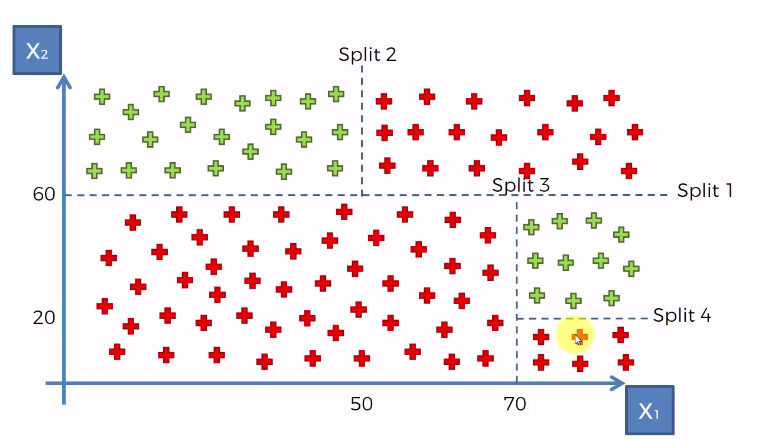

# Decision tree classifier
К счатью для нас, алгоритм дерева решений уже реализован в библиотеке sklearn.
В данном случае, так как мы решаем задачу бинарной классификации, то воспользуемся классом `DecisionTreeClassifier`.

    class sklearn.tree.DecisionTreeClassifier(*, criterion='gini',
    splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1,
    min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
    class_weight=None, ccp_alpha=0.0)

In [10]:
# Define the model hyperparameters

params = {
    'max_depth': 5,
    'min_samples_leaf': 10,
    'min_samples_split': 2,
    'criterion': 'entropy'
}

clf = DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_clf = accuracy_score(y_test, pred)
f1_score_clf = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)

# Start an MLflow run
with mlflow.start_run(run_name='Baseline'):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_clf)
    mlflow.log_metric("f1_score", f1_score_clf)
    mlflow.log_metric("roc_auc", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for Titanic data")

    # Infer the model signature
    signature = infer_signature(X_train, pred)

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="Titanic_tree_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="Titanic_tree_model_baseline",
    )


print(classification_report(y_test, pred))

Successfully registered model 'Titanic_tree_model_baseline'.
2024/07/24 20:56:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic_tree_model_baseline, version 1


              precision    recall  f1-score   support

           0       0.78      0.88      0.83       161
           1       0.77      0.61      0.68       106

    accuracy                           0.78       267
   macro avg       0.77      0.75      0.75       267
weighted avg       0.78      0.78      0.77       267



Created version '1' of model 'Titanic_tree_model_baseline'.


Всего три строчки кода, и мы обучили дерево решений!

# Feature importance

**Важность признака** - доля признака в Information Gain.

In [11]:
clf.feature_importances_

array([0.19547225, 0.48145922, 0.10301063, 0.03455633, 0.0205295 ,
       0.16497207, 0.        , 0.        , 0.        ])

In [12]:
pd.DataFrame(clf.feature_importances_, index = list(X_columns), columns = ['feature importance']).sort_values('feature importance', ascending = False)

,feature importance
Sex,0.481459
Pclass,0.195472
Fare,0.164972
Age,0.103011
SibSp,0.034556
Parch,0.020530
Embarked=C,0.000000
Embarked=Q,0.000000
Embarked=S,0.000000


# Оптимизация гиперпараметров

Давайте подберем оптимальный набор гиперпараметров для нашей модели. Для этого воспользуемся методом GridSearch на кросс-валидации. Будем использовать метод  `GridSearchCV` из библиотеки sklearn.

In [13]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeClassifier()

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 10, 12, 14],
              'min_samples_split' : [2, 5, 10, 20],
              'min_samples_leaf':[1, 5, 10, 50],
              'criterion':['gini', 'entropy']}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=5)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [14]:
pred = gs.predict(X_test)
accuracy_gs = accuracy_score(y_test, pred)
f1_score_gs = f1_score(y_test, pred)
roc_auc_gs = roc_auc_score(y_test, pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       161
           1       0.85      0.62      0.72       106

    accuracy                           0.81       267
   macro avg       0.82      0.77      0.78       267
weighted avg       0.81      0.81      0.80       267



Отлично! Качество возросло!

In [15]:
with mlflow.start_run(run_name='Optimisation'):
    # Log the hyperparameters
    mlflow.log_params(gs.best_params_)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_gs)
    mlflow.log_metric("f1_score", f1_score_gs)
    mlflow.log_metric("roc_auc", roc_auc_gs)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Optimized model for Titanic data")

    # Infer the model signature
    signature = infer_signature(X_train, pred)

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=gs,
        artifact_path="MLOps/Open_day_MLFlow/code/Titanic_tree_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="Titanic_tree_model_optimized",
    )

Successfully registered model 'Titanic_tree_model_optimized'.
2024/07/24 20:57:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic_tree_model_optimized, version 1
Created version '1' of model 'Titanic_tree_model_optimized'.


## А как загрузить модель:

In [16]:
sklearn_pyfunc = mlflow.pyfunc.load_model(model_uri=model_info.model_uri)

In [17]:
pred_load = sklearn_pyfunc.predict(X_test)
print(classification_report(y_test, pred_load))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       161
           1       0.85      0.62      0.72       106

    accuracy                           0.81       267
   macro avg       0.82      0.77      0.78       267
weighted avg       0.81      0.81      0.80       267



In [18]:
model_info.model_uri

'runs:/679f455908464a7fa5dd2ba19a183b52/MLOps/Open_day_MLFlow/code/Titanic_tree_model'